# Chapter 3 — Interactive Companion: Scalar Mixing
Prepared by Prof. Bhaganagar

This notebook is companion notebook for Chapter 3 (Turbulence Mixing). It blends concise theory with interactive activities

## 0. Core equations (quick reference)
Mixing-length closure:
$$
\nu_t = \ell_m^2\,\left|\frac{\partial U}{\partial y}\right|,\qquad \kappa_t = \frac{\nu_t}{Pr_t}.
$$
Scalar flux & variance production:
$$
q_y = -\,\kappa_t\,\overline{T}_y,\qquad P_\theta = 2\,\kappa_t\,\overline{T}_y^2.
$$
Diffusion-form means (1D):
$$
\frac{\partial U}{\partial t}=\frac{\partial}{\partial y}\big[(\nu+\nu_t)U_y\big],\quad
\frac{\partial \overline{T}}{\partial t}=\frac{\partial}{\partial y}\big[(\alpha+\kappa_t)\overline{T}_y\big].
$$

In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Dropdown, IntSlider
import ch3_scalar_mixing as ch3
pd.options.display.float_format = "{:.6g}".format
print("Setup OK")

Setup OK


## A. Shear-driven mixing — Mixing-length model
Outer scaling: $\ell_m \approx \kappa y$ (away from walls); closure $\nu_t=\ell_m^2|U_y|$, $\kappa_t=\nu_t/Pr_t$.

### A.1 Theory — Linear mixing length and Van Driest damping
Linear mixing length (outer): $\ell_m=\kappa y$, $\kappa\approx0.41$.
Near walls, turbulence must be damped. Van Driest modifies $\ell_m$ in wall units $y^+=y u_\tau/\nu$:
$$
\boxed{ \ \ell_m(y) = \kappa\,y \left[ 1 - \exp\!\left( -\,\dfrac{y^+}{A^+} \right) \right]^m \ },
\qquad y^+ \equiv \frac{y\,u_\tau}{\nu}.
$$
Here $A^+\approx 26$ and $m\in\{1,2\}$. As $y^+\to 0$, $\ell_m\propto y^{\,1+m}$ (e.g. $y^2$ for $m=1$), forcing $\nu_t\to0$ at the wall.

In [ ]:
# Compare ℓ_m = κ y vs Van Driest, and induced ν_t
def vd_ell_m(y, kappa=0.41, u_tau=0.05, nu=1.5e-5, A_plus=26.0, m=1):
    y = np.asarray(y); y_plus = y*u_tau/nu
    return kappa*y*(1.0 - np.exp(-y_plus/A_plus))**m

def demo_vandriest(L=0.1, n=400, kappa=0.41, u_tau=0.05, nu=1.5e-5, A_plus=26.0, m=1,
                   shear='Constant', S0=500.0, decay=0.02):
    y = np.linspace(0, L, int(n))
    lm_linear = kappa*y
    lm_vd = vd_ell_m(y, kappa, u_tau, nu, A_plus, m)
    dUdy = np.full_like(y, S0) if shear=='Constant' else S0*np.exp(-y/decay)
    nu_t_linear = ch3.eddy_viscosity(lm_linear, dUdy)
    nu_t_vd     = ch3.eddy_viscosity(lm_vd, dUdy)

    plt.figure(); plt.plot(y, lm_linear, label="ℓ_m = κ y"); plt.plot(y, lm_vd, label="Van Driest ℓ_m"); 
    plt.xlabel("y (m)"); plt.ylabel("ℓ_m (m)"); plt.title("Mixing length"); plt.legend(); plt.grid(True); plt.show()

    plt.figure(); plt.semilogy(y, np.maximum(nu_t_linear,1e-12), label="ν_t (κ y)")
    plt.semilogy(y, np.maximum(nu_t_vd,1e-12), label="ν_t (Van Driest)")
    plt.xlabel("y (m)"); plt.ylabel("ν_t (m²/s)"); plt.title("Eddy viscosity"); plt.legend(); plt.grid(True, which='both'); plt.show()

interact(
    demo_vandriest,
    L=FloatSlider(value=0.1, min=0.02, max=0.5, step=0.01, description="L (m)"),
    n=IntSlider(value=400, min=100, max=1200, step=50, description="n"),
    kappa=FloatSlider(value=0.41, min=0.2, max=0.6, step=0.01, description="κ"),
    u_tau=FloatSlider(value=0.05, min=0.01, max=0.5, step=0.01, description="u_τ"),
    nu=FloatSlider(value=1.5e-5, min=5e-7, max=5e-5, step=5e-7, readout_format=".1e", description="ν"),
    A_plus=FloatSlider(value=26.0, min=10.0, max=40.0, step=1.0, description="A⁺"),
    m=IntSlider(value=1, min=1, max=2, step=1, description="m"),
    shear=Dropdown(options=['Constant','Exponential'], value='Constant', description='Shear'),
    S0=FloatSlider(value=500.0, min=50.0, max=2000.0, step=50.0, description="S₀"),
    decay=FloatSlider(value=0.02, min=0.005, max=0.2, step=0.005, description="decay"),
);

## B. Steady diffusion-form solvers (1D)
Solve (steady) $\frac{d}{dy}[(\nu+\nu_t)U_y]=0$ and $\frac{d}{dy}[(\alpha+\kappa_t)\overline{T}_y]=0$ with Dirichlet BCs.

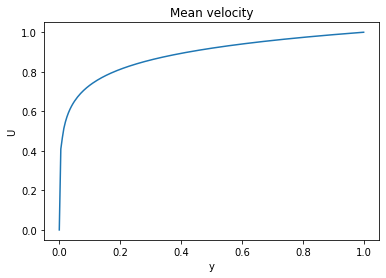

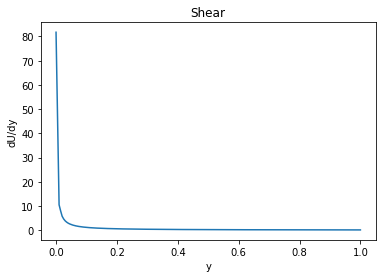

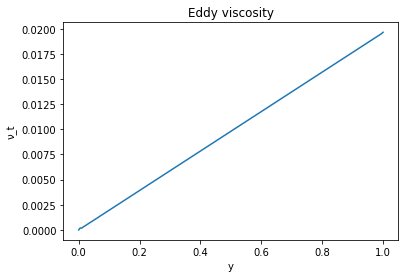

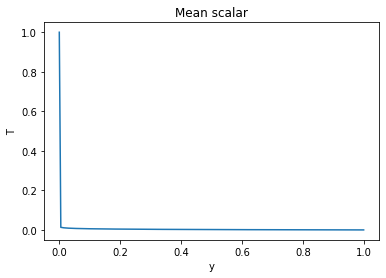

In [5]:
import numpy as np, matplotlib.pyplot as plt

def solve_steady_diffusion(y, mu_eff, bc0, bc1):
    y = np.asarray(y); mu = np.asarray(mu_eff)
    n = len(y); dy = y[1]-y[0]
    A = np.zeros((n,n)); b = np.zeros(n)
    A[0,0] = 1.0; b[0] = bc0
    A[-1,-1] = 1.0; b[-1] = bc1
    for i in range(1,n-1):
        mu_w = 2*mu[i-1]*mu[i]/(mu[i-1]+mu[i])
        mu_e = 2*mu[i]*mu[i+1]/(mu[i]+mu[i+1])
        A[i,i-1] =  mu_w/(dy*dy)
        A[i,i]   = -(mu_w+mu_e)/(dy*dy)
        A[i,i+1] =  mu_e/(dy*dy)
    φ = np.linalg.solve(A,b)
    return φ

def momentum_scalar_solver(n=201, L=1.0, nu=1.5e-5, alpha=1.4e-7, kappa=0.41, Pr_t=0.9,
                           U0=0.0, U1=1.0, T0=1.0, T1=0.0, max_iter=30):
    y = np.linspace(0, L, int(n))
    U = np.linspace(U0, U1, int(n))
    for it in range(int(max_iter)):
        dUdy = np.gradient(U, y)
        lm = kappa*y
        nu_t = (lm**2)*np.abs(dUdy)
        mu_eff = nu + nu_t
        U_new = solve_steady_diffusion(y, mu_eff, U0, U1)
        if np.max(np.abs(U_new-U)) < 1e-6:
            U = U_new; break
        U = 0.5*U + 0.5*U_new
    kappa_t = nu_t/Pr_t
    alpha_eff = alpha + kappa_t
    T = solve_steady_diffusion(y, alpha_eff, T0, T1)

    plt.figure(); plt.plot(y, U); plt.xlabel("y"); plt.ylabel("U"); plt.title("Mean velocity"); plt.show()
    plt.figure(); plt.plot(y, np.gradient(U, y)); plt.xlabel("y"); plt.ylabel("dU/dy"); plt.title("Shear"); plt.show()
    plt.figure(); plt.plot(y, nu_t); plt.xlabel("y"); plt.ylabel("ν_t"); plt.title("Eddy viscosity"); plt.show()
    plt.figure(); plt.plot(y, T); plt.xlabel("y"); plt.ylabel("T"); plt.title("Mean scalar"); plt.show()

# Demo run
momentum_scalar_solver()

## C. Buoyancy effects — $N^2$ and $Ri_g$
$N^2=\frac{g}{\Theta_0}\,\overline{\Theta}_z$, \quad $Ri_g = N^2/(U_y)^2$.
Stable: $N^2>0$; Unstable: $N^2<0$.

In [6]:
def buoy_demo(L=1.0, n=300, S0=10.0, decay=0.4, N2_0=0.02, N2_slope=0.0, Pr_t=0.9, kappa=0.41):
    y = np.linspace(0, L, int(n))
    dUdy = S0*np.exp(-y/decay)
    lm = kappa*y
    nu_t = (lm**2)*np.abs(dUdy)
    kappa_t = nu_t/Pr_t
    N2 = N2_0 + N2_slope*(y - L/2.0)
    Ri_g = N2 / np.maximum(dUdy**2, 1e-12)

    plt.figure(); plt.plot(y, N2); plt.xlabel("y"); plt.ylabel("N²"); plt.title("Stability"); plt.show()
    plt.figure(); plt.plot(y, Ri_g); plt.xlabel("y"); plt.ylabel("Ri_g"); plt.title("Gradient Richardson"); plt.show()
    plt.figure(); plt.plot(y, kappa_t); plt.xlabel("y"); plt.ylabel("κ_t"); plt.title("Eddy diffusivity"); plt.show()

from ipywidgets import interact, FloatSlider
interact(
    buoy_demo,
    L=FloatSlider(value=1.0, min=0.2, max=5.0, step=0.1, description="L"),
    n=IntSlider(value=300, min=50, max=800, step=10, description="n"),
    S0=FloatSlider(value=10.0, min=0.5, max=40.0, step=0.5, description="S0"),
    decay=FloatSlider(value=0.4, min=0.05, max=2.0, step=0.05, description="decay"),
    N2_0=FloatSlider(value=0.02, min=-0.05, max=0.1, step=0.005, description="N² @ mid"),
    N2_slope=FloatSlider(value=0.0, min=-0.2, max=0.2, step=0.005, description="N² slope"),
    Pr_t=FloatSlider(value=0.9, min=0.5, max=1.5, step=0.05, description="Pr_t"),
    kappa=FloatSlider(value=0.41, min=0.2, max=0.6, step=0.01, description="κ"),
);

interactive(children=(FloatSlider(value=1.0, description='L', max=5.0, min=0.2), IntSlider(value=300, descript…

## D. Density current (gravity current) — interactive example

A dense fluid of thickness \(h\) propagates under a light ambient due to reduced gravity \(g' = g\,\Delta\rho/\rho_0\).
A simple bulk model uses a front Froude number \(Fr\) so the front speed is
\[
U \;\approx\; Fr\,\sqrt{g'\,h}.
\]
Entrainment from the ambient thickens and dilutes the current. With an entrainment coefficient \(E\) (dimensionless),
the thickness growth and dilution over distance \(x\) follow the box model
\[
\frac{dh}{dx} = E, \qquad \frac{d(\Delta C)}{dx} = -\,\frac{E}{h}\,\Delta C
\;\;\Rightarrow\;\;
h(x)=h_0+E x,\quad \Delta C(x)=\Delta C_0\,\frac{h_0}{h_0+E x}.
\]
As a rough link to mixing-length ideas, we can estimate a shear scale \(S\sim U/h\) and a length scale limited by the
layer depth \(\ell_m \sim \min(\kappa y,\,\gamma h)\). Then \(\nu_t\sim \ell_m^2 |S|\) and \(\kappa_t=\nu_t/Pr_t\),
giving a proxy for interfacial scalar flux \(q\sim -\kappa_t\,\Delta C/\delta\) with \(\delta=\gamma h\).

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

g = 9.81

def density_current_demo(
    L=200.0, n=400,
    rho0=1000.0, drho=2.0,  # kg/m^3
    h0=0.5, Fr=0.9, E=0.02,   # entrainment coeff
    kappa=0.41, gamma=0.1, Pr_t=0.9
):
    \"\"\"
    1D box model along x: h' = E, DeltaC' = -(E/h) DeltaC, U = Fr*sqrt(g' h).
    Simple mixing-length proxy for nu_t and kappa_t; flux q ~ -kappa_t * (DeltaC/delta) with delta=gamma h.
    \"\"\"
    x = np.linspace(0, L, int(n))
    h = h0 + E*x
    gprime = g*(drho/rho0)
    U = Fr*np.sqrt(np.maximum(gprime*h, 1e-12))
    DeltaC0 = 1.0  # arbitrary scalar difference; results scale linearly
    DeltaC = DeltaC0 * (h0/h)

    # Proxy mixing parameters near interface
    # Shear scale S ~ U/h ; length scale limited by gamma h
    S = np.maximum(U/np.maximum(h,1e-12), 1e-12)
    ell_m = gamma*h
    nu_t = (ell_m**2)*S
    kappa_t = nu_t/Pr_t
    delta = gamma*h
    q = -kappa_t*(DeltaC/np.maximum(delta,1e-12))

    # Plots
    plt.figure(); plt.plot(x, h); plt.xlabel("x (m)"); plt.ylabel("h (m)"); plt.title("Layer thickness h(x)"); plt.grid(True); plt.show()
    plt.figure(); plt.plot(x, U); plt.xlabel("x (m)"); plt.ylabel("U (m/s)"); plt.title("Front speed scale U(x)"); plt.grid(True); plt.show()
    plt.figure(); plt.plot(x, DeltaC); plt.xlabel("x (m)"); plt.ylabel("DeltaC (nondim)"); plt.title("Dilution ΔC(x)"); plt.grid(True); plt.show()
    plt.figure(); plt.plot(x, kappa_t); plt.xlabel("x (m)"); plt.ylabel("kappa_t (m^2/s)"); plt.title("Eddy diffusivity proxy κ_t(x)"); plt.grid(True); plt.show()
    plt.figure(); plt.plot(x, q); plt.xlabel("x (m)"); plt.ylabel("q (arb units)"); plt.title("Interfacial scalar flux proxy q(x)"); plt.grid(True); plt.show()

interact(
    density_current_demo,
    L=FloatSlider(value=200.0, min=20.0, max=2000.0, step=10.0, description="Domain L (m)"),
    n=IntSlider(value=400, min=100, max=2000, step=50, description="Grid n"),
    rho0=FloatSlider(value=1000.0, min=900.0, max=1030.0, step=1.0, description="rho0 (kg/m^3)"),
    drho=FloatSlider(value=2.0, min=0.1, max=20.0, step=0.1, description="Delta rho (kg/m^3)"),
    h0=FloatSlider(value=0.5, min=0.05, max=5.0, step=0.05, description="h0 (m)"),
    Fr=FloatSlider(value=0.9, min=0.2, max=1.5, step=0.05, description="Fr"),
    E=FloatSlider(value=0.02, min=0.0, max=0.2, step=0.005, description="E"),
    kappa=FloatSlider(value=0.41, min=0.2, max=0.6, step=0.01, description="kappa"),
    gamma=FloatSlider(value=0.1, min=0.02, max=0.5, step=0.01, description="gamma (delta=gamma h)"),
    Pr_t=FloatSlider(value=0.9, min=0.5, max=2.0, step=0.05, description="Pr_t"),
);

## E. Synthetic shear data examples (from Shear Companion)

These examples reproduce the *synthetic* profiles used in the Shear companion notebook and show how to
build \(\nu_t,\ \kappa_t,\ q_y,\ P_\theta\) from \(\ell_m,\ U_y,\ Pr_t,\ \overline{T}_y\). They are handy for unit checks and plotting.

### E.1 Example A — Toy profile (clean, noise-free)
Take \(\ell_m(y)=0.1\,y\) on \(y\in[0,1]\), shear \(U_y(y)=20\,e^{-y/0.3}\,\mathrm{s^{-1}}\), \(Pr_t=0.9\),
and scalar gradient \(\overline{T}_y=-30(1-y)\,\mathrm{K\,m^{-1}}\).

In [7]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

y = np.linspace(0, 1, 201)
lm = 0.1*y
dUdy = 20.0*np.exp(-y/0.3)
Pr_t = 0.9
dTdy = -30.0*(1 - y)

nu_t    = (lm**2)*np.abs(dUdy)
kappa_t = nu_t/Pr_t
q_y     = -kappa_t*dTdy
P_theta = 2.0*kappa_t*(dTdy**2)

toy = pd.DataFrame({
    "y": y, "lm_m": lm, "S_1_per_s": dUdy, "Pr_t": Pr_t,
    "nu_t_m2_per_s": nu_t, "kappa_t_m2_per_s": kappa_t,
    "dTdy_K_per_m": dTdy, "q_y_K_m_per_s": q_y, "P_theta_K2_per_s": P_theta
})
toy.head()

,y,lm_m,S_1_per_s,Pr_t,nu_t_m2_per_s,kappa_t_m2_per_s,dTdy_K_per_m,q_y_K_m_per_s,P_theta_K2_per_s
0,0,0,20,0.9,0,0,-30,0,0
1,0.005,0.0005,19.6694,0.9,4.91736e-06,5.46373e-06,-29.85,0.000163092,0.00973661
2,0.01,0.001,19.3443,0.9,1.93443e-05,2.14937e-05,-29.7,0.000638363,0.0379187
3,0.015,0.0015,19.0246,0.9,4.28053e-05,4.75615e-05,-29.55,0.00140544,0.0830616
4,0.02,0.002,18.7101,0.9,7.48406e-05,8.31562e-05,-29.4,0.00244479,0.143754


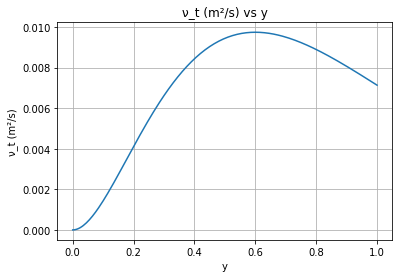

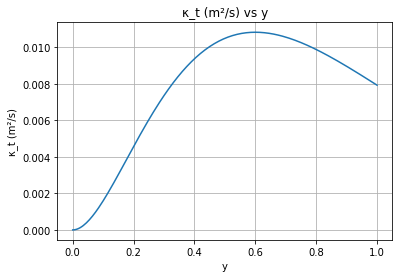

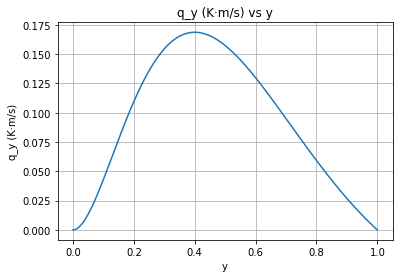

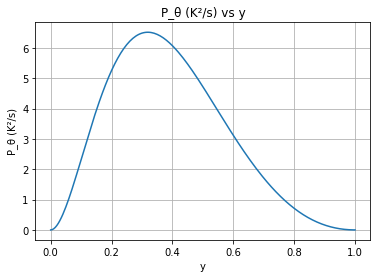

In [8]:
# Quick plots
for col, lab in [
    ("nu_t_m2_per_s","ν_t (m²/s)"),
    ("kappa_t_m2_per_s","κ_t (m²/s)"),
    ("q_y_K_m_per_s","q_y (K·m/s)"),
    ("P_theta_K2_per_s","P_θ (K²/s)")]:
    plt.figure(); plt.plot(toy["y"], toy[col]); plt.xlabel("y"); plt.ylabel(lab); plt.title(lab+" vs y"); plt.grid(True); plt.show()

### E.2 Example B — Add synthetic noise & save CSV
We add small Gaussian noise to mimic measurement scatter and optionally save a CSV (`Synthetic_ShearDemo.csv`).

In [9]:
rng = np.random.default_rng(42)
noise_level = 0.03  # 3% relative noise
lm_n   = lm*(1 + noise_level*rng.standard_normal(lm.shape))
dUdy_n = dUdy*(1 + noise_level*rng.standard_normal(dUdy.shape))
Pr_t_n = 0.9  # keep constant here
dTdy_n = dTdy*(1 + noise_level*rng.standard_normal(dTdy.shape))

nu_t_n    = (lm_n**2)*np.abs(dUdy_n)
kappa_t_n = nu_t_n/Pr_t_n
q_y_n     = -kappa_t_n*dTdy_n
P_theta_n = 2.0*kappa_t_n*(dTdy_n**2)

syn = pd.DataFrame({
    "y": y, "lm_m": lm_n, "S_1_per_s": dUdy_n, "Pr_t": Pr_t_n,
    "nu_t_m2_per_s": nu_t_n, "kappa_t_m2_per_s": kappa_t_n,
    "dTdy_K_per_m": dTdy_n, "q_y_K_m_per_s": q_y_n, "P_theta_K2_per_s": P_theta_n
})
syn.to_csv("Synthetic_ShearDemo.csv", index=False)
print("Saved Synthetic_ShearDemo.csv")
syn.head()

Saved Synthetic_ShearDemo.csv


,y,lm_m,S_1_per_s,Pr_t,nu_t_m2_per_s,kappa_t_m2_per_s,dTdy_K_per_m,q_y_K_m_per_s,P_theta_K2_per_s
0,0,0,20.8445,0.9,0,0,-30.7385,0,0
1,0.005,0.0004844,19.7229,0.9,4.62785e-06,5.14205e-06,-29.4974,0.000151677,0.00894817
2,0.01,0.00102251,19.718,0.9,2.06159e-05,2.29065e-05,-30.1644,0.00069096,0.0416847
3,0.015,0.00154233,17.8545,0.9,4.24717e-05,4.71907e-05,-29.3143,0.00138336,0.0811048
4,0.02,0.00188294,18.6828,0.9,6.6239e-05,7.35989e-05,-29.2963,0.00215618,0.126336


### E.3 Example C — Reconstruct from columns and compare
Recompute \(\nu_t,\ \kappa_t\) from \(\ell_m, U_y, Pr_t\) and compare with the (noisy) columns.

In [10]:
# Recompute from the noisy columns
nu_t_re  = (syn["lm_m"].values**2)*np.abs(syn["S_1_per_s"].values)
kappa_re = nu_t_re/Pr_t_n

cmp = pd.DataFrame({
    "y": syn["y"],
    "nu_t (orig)": syn["nu_t_m2_per_s"],
    "nu_t (re)":   nu_t_re,
    "kappa_t (orig)": syn["kappa_t_m2_per_s"],
    "kappa_t (re)":   kappa_re
})
cmp.head()

,y,nu_t (orig),nu_t (re),kappa_t (orig),kappa_t (re)
0,0,0,0,0,0
1,0.005,4.62785e-06,4.62785e-06,5.14205e-06,5.14205e-06
2,0.01,2.06159e-05,2.06159e-05,2.29065e-05,2.29065e-05
3,0.015,4.24717e-05,4.24717e-05,4.71907e-05,4.71907e-05
4,0.02,6.6239e-05,6.6239e-05,7.35989e-05,7.35989e-05


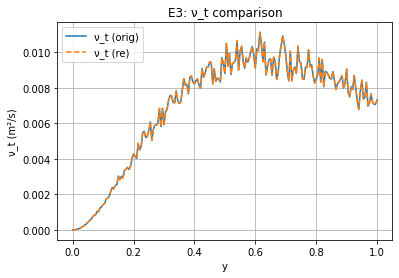

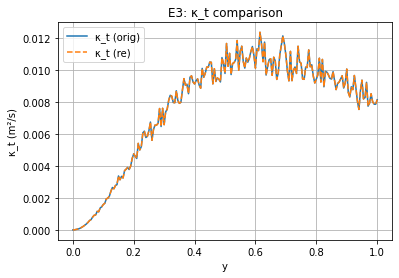

In [11]:
plt.figure(); plt.plot(cmp["y"], cmp["nu_t (orig)"], label="ν_t (orig)"); plt.plot(cmp["y"], cmp["nu_t (re)"], '--', label="ν_t (re)")
plt.xlabel("y"); plt.ylabel("ν_t (m²/s)"); plt.title("E3: ν_t comparison"); plt.legend(); plt.grid(True); plt.show()

plt.figure(); plt.plot(cmp["y"], cmp["kappa_t (orig)"], label="κ_t (orig)"); plt.plot(cmp["y"], cmp["kappa_t (re)"], '--', label="κ_t (re)")
plt.xlabel("y"); plt.ylabel("κ_t (m²/s)"); plt.title("E3: κ_t comparison"); plt.legend(); plt.grid(True); plt.show()

## F. Self‑assessment (quick)
1) What role does $m$ play in Van Driest damping?
2) Why is $\ell_m=\kappa y$ inadequate at small $y^+$?
3) If $Pr_t$ increases with $Ri_g$, what happens to scalar flux magnitude for fixed $\nu_t$?

## G. Homework (practical)
- HVAC ceiling jet near a wall: compute $\nu_t,\kappa_t,q_y,P_\theta$ and solve steady momentum with $\nu+\nu_t(y)$; discuss where $P_\theta$ peaks.
- River outfall with weak stratification: compute $Ri_g(y)$ and mark regions $>0.25$; compare $q_y$ for $Pr_t=0.85$ vs $0.7$.
- Stack plume: compare $N^2=+0.01,0,-0.01\ \mathrm{s^{-2}}$ impacts on $q_y$ with the same $\kappa_t$.

## E. Synthetic data examples (Shear) — like the Shear Companion

We create **toy shear datasets** that match the column layout used in the Shear Companion:
\(`y, S_1_per_s, lm_m, nu_t_m2_per_s, Pr_t, kappa_t_m2_per_s, dTdy_K_per_m, P_theta_K2_per_s, q_y_K_m_per_s`\).

Two quick cases:
- **Example S1 (exponential shear)**: \( \ell_m= a\,y\), \(S(y)=S_0 e^{-y/\delta}\), constant \(Pr_t\), graded \(\overline{T}_y\).
- **Example S2 (piecewise shear)**: constant \(S\) core with near-wall ramp; change \(Pr_t\) and gradient form.

### E.1 Interactive generator & exporter (Synthetic Shear Datasets)

Use the panel to tweak parameters and instantly regenerate a synthetic shear dataset.
You can export the current dataset to CSV by toggling **Save CSV**.

In [12]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown, ToggleButtons, Text

def make_synth_shear(n=201, L=1.0, profile='Exponential', a=0.1,
                     S0=20.0, delta=0.3, S_const=15.0,
                     Pr_t=0.9, Tgrad_form='Linear', Tgrad0=-30.0,
                     filename="Shear_SYNTH.csv", save_csv=False):
    y = np.linspace(0, L, int(n))
    lm = a*y
    if profile == 'Exponential':
        S = S0*np.exp(-y/delta)
    elif profile == 'Piecewise':
        y_core = 0.6*L
        ramp = 30.0
        S = np.where(y<y_core, ramp*(y/y_core), S_const)
    else:
        S = np.full_like(y, S_const)
    nu_t = (lm**2)*np.abs(S)
    kappa_t = nu_t/Pr_t
    if Tgrad_form == 'Linear':
        dTdy = Tgrad0*(1 - y/L)
    else:
        dTdy = Tgrad0*np.ones_like(y)
    q_y = -kappa_t*dTdy
    P_theta = 2.0*kappa_t*(dTdy**2)
    df = pd.DataFrame({
        "y":y, "S_1_per_s":S, "lm_m":lm, "nu_t_m2_per_s":nu_t, "Pr_t":Pr_t,
        "kappa_t_m2_per_s":kappa_t, "dTdy_K_per_m":dTdy, "P_theta_K2_per_s":P_theta, "q_y_K_m_per_s":q_y
    })
    # Show preview
    display(df.head())

    # Plots (one per figure, default styles)
    for arr, lab in [(nu_t,"ν_t (m²/s)"), (kappa_t,"κ_t (m²/s)"), (q_y,"q_y (K·m/s)"), (P_theta,"P_θ (K²/s)") ]:
        plt.figure(); plt.plot(y, arr); plt.xlabel("y"); plt.ylabel(lab); plt.title(lab+" vs y"); plt.grid(True); plt.show()

    if save_csv:
        df.to_csv(filename, index=False)
        print(f"Saved CSV -> {filename}")
    return df

interact(
    make_synth_shear,
    n=IntSlider(value=201, min=101, max=2001, step=50, description="Grid n"),
    L=FloatSlider(value=1.0, min=0.2, max=5.0, step=0.1, description="Domain L"),
    profile=Dropdown(options=['Exponential','Piecewise','Constant'], value='Exponential', description='Shear profile'),
    a=FloatSlider(value=0.1, min=0.02, max=0.5, step=0.01, description="ℓ_m coeff a"),
    S0=FloatSlider(value=20.0, min=1.0, max=60.0, step=1.0, description="S0 (exp)"),
    delta=FloatSlider(value=0.3, min=0.05, max=1.5, step=0.05, description="decay (exp)"),
    S_const=FloatSlider(value=15.0, min=1.0, max=60.0, step=1.0, description="S const"),
    Pr_t=FloatSlider(value=0.9, min=0.5, max=1.5, step=0.05, description="Pr_t"),
    Tgrad_form=Dropdown(options=['Linear','Constant'], value='Linear', description='∂T/∂y form'),
    Tgrad0=FloatSlider(value=-30.0, min=-200.0, max=0.0, step=5.0, description="∂T/∂y scale"),
    filename=Text(value="Chapter3Companion_ScalarMixing_Shear_SYNTH.csv", description="File"),
    save_csv=ToggleButtons(options=[False, True], value=False, description="Save CSV")
);

interactive(children=(IntSlider(value=201, description='Grid n', max=2001, min=101, step=50), FloatSlider(valu…

In [15]:
import numpy as np, pandas as pd

def synth_shear_example_S1(n=201, L=1.0, a=0.1, S0=20.0, delta=0.3, Pr_t=0.9, Tgrad0=-30.0):
    y = np.linspace(0, L, n)
    lm = a*y
    S  = S0*np.exp(-y/delta)
    nu_t = (lm**2)*np.abs(S)
    kappa_t = nu_t/Pr_t
    dTdy = Tgrad0*(1 - y/L)
    q_y = -kappa_t*dTdy
    P_theta = 2.0*kappa_t*(dTdy**2)
    return pd.DataFrame({
        "y":y, "S_1_per_s":S, "lm_m":lm, "nu_t_m2_per_s":nu_t, "Pr_t":Pr_t,
        "kappa_t_m2_per_s":kappa_t, "dTdy_K_per_m":dTdy, "P_theta_K2_per_s":P_theta, "q_y_K_m_per_s":q_y
    })

def synth_shear_example_S2(n=201, L=1.0, a=0.08, S_core=15.0, y_core=0.6, ramp=30.0, Pr_t=0.85, Tgrad=-40.0):
    y = np.linspace(0, L, n)
    lm = a*y
    S  = np.where(y<y_core, ramp*(y/y_core), S_core)   # ramp-up to core constant S
    nu_t = (lm**2)*np.abs(S)
    kappa_t = nu_t/Pr_t
    dTdy = Tgrad*np.ones_like(y)
    q_y = -kappa_t*dTdy
    P_theta = 2.0*kappa_t*(dTdy**2)
    return pd.DataFrame({
        "y":y, "S_1_per_s":S, "lm_m":lm, "nu_t_m2_per_s":nu_t, "Pr_t":Pr_t,
        "kappa_t_m2_per_s":kappa_t, "dTdy_K_per_m":dTdy, "P_theta_K2_per_s":P_theta, "q_y_K_m_per_s":q_y
    })

df_S1 = synth_shear_example_S1()
df_S2 = synth_shear_example_S2()
df_S1.head(), df_S2.head()

(      y  S_1_per_s   lm_m  nu_t_m2_per_s  Pr_t  kappa_t_m2_per_s  \
 0     0         20      0              0   0.9                 0   
 1 0.005    19.6694 0.0005    4.91736e-06   0.9       5.46373e-06   
 2  0.01    19.3443  0.001    1.93443e-05   0.9       2.14937e-05   
 3 0.015    19.0246 0.0015    4.28053e-05   0.9       4.75615e-05   
 4  0.02    18.7101  0.002    7.48406e-05   0.9       8.31562e-05   
 
    dTdy_K_per_m  P_theta_K2_per_s  q_y_K_m_per_s  
 0           -30                 0              0  
 1        -29.85        0.00973661    0.000163092  
 2         -29.7         0.0379187    0.000638363  
 3        -29.55         0.0830616     0.00140544  
 4         -29.4          0.143754     0.00244479  ,
       y  S_1_per_s   lm_m  nu_t_m2_per_s  Pr_t  kappa_t_m2_per_s  \
 0     0          0      0              0  0.85                 0   
 1 0.005       0.25 0.0004          4e-08  0.85       4.70588e-08   
 2  0.01        0.5 0.0008        3.2e-07  0.85       3.76471e-0

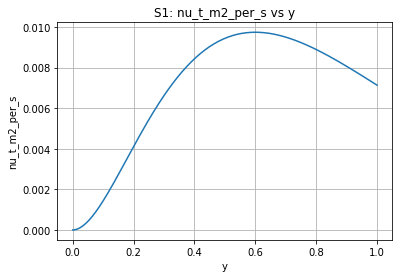

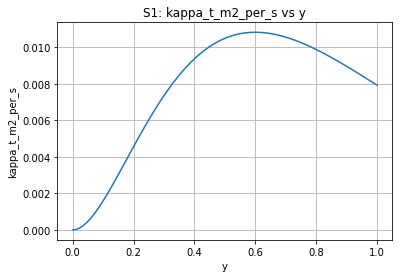

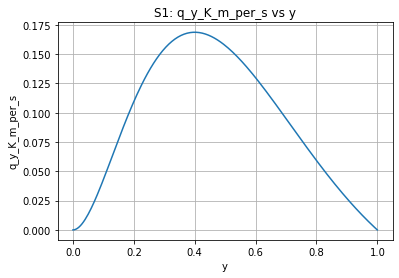

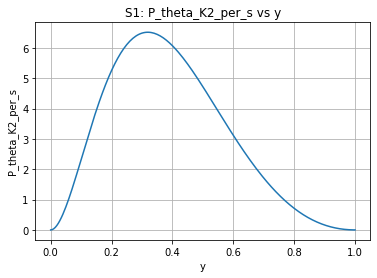

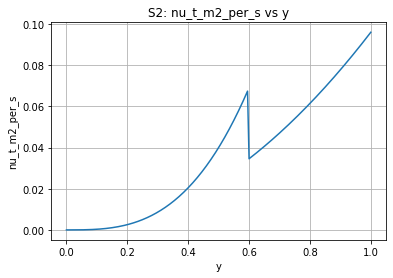

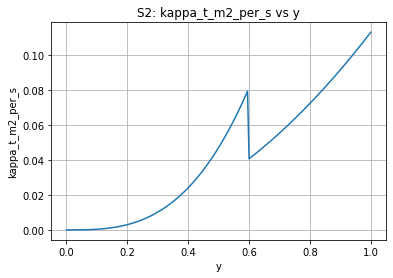

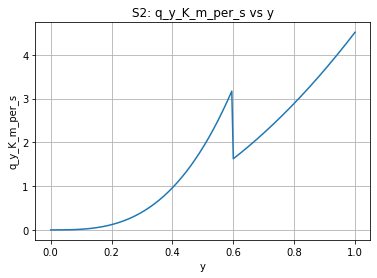

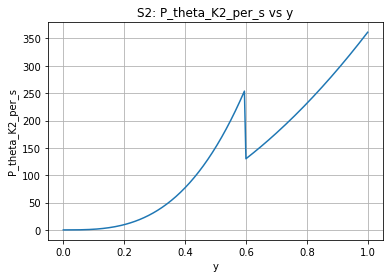

In [16]:
import matplotlib.pyplot as plt

def quick_plot(df, title_prefix="Synthetic"):
    cols = ["nu_t_m2_per_s","kappa_t_m2_per_s","q_y_K_m_per_s","P_theta_K2_per_s"]
    for c in cols:
        plt.figure(); plt.plot(df["y"], df[c]); plt.xlabel("y"); plt.ylabel(c); plt.title(f"{title_prefix}: {c} vs y"); plt.grid(True); plt.show()

quick_plot(df_S1, "S1"); quick_plot(df_S2, "S2")

In [17]:
# Rebuild from columns using the helper and compare (sanity check)
import ch3_scalar_mixing as ch3
re_S1 = ch3.shear_mixing_from_profile(df_S1["y"], df_S1["lm_m"], df_S1["S_1_per_s"], df_S1["Pr_t"], df_S1["dTdy_K_per_m"])
re_S2 = ch3.shear_mixing_from_profile(df_S2["y"], df_S2["lm_m"], df_S2["S_1_per_s"], df_S2["Pr_t"], df_S2["dTdy_K_per_m"])

cmp = df_S1[["y","nu_t_m2_per_s","kappa_t_m2_per_s"]].copy()
cmp["nu_t (recon)"] = re_S1["nu_t_m2_per_s"]
cmp["kappa_t (recon)"] = re_S1["kappa_t_m2_per_s"]
cmp.head()

,y,nu_t_m2_per_s,kappa_t_m2_per_s,nu_t (recon),kappa_t (recon)
0,0,0,0,0,0
1,0.005,4.91736e-06,5.46373e-06,4.91736e-06,5.46373e-06
2,0.01,1.93443e-05,2.14937e-05,1.93443e-05,2.14937e-05
3,0.015,4.28053e-05,4.75615e-05,4.28053e-05,4.75615e-05
4,0.02,7.48406e-05,8.31562e-05,7.48406e-05,8.31562e-05


In [ ]:
# Optional: Save synthetic datasets alongside the notebook for reuse
df_S1.to_csv("Chapter3Companion_ScalarMixing_Shear_SYNTH_S1.csv", index=False)
df_S2.to_csv("Chapter3Companion_ScalarMixing_Shear_SYNTH_S2.csv", index=False)
print("Wrote: Chapter3Companion_ScalarMixing_Shear_SYNTH_S1.csv, Chapter3Companion_ScalarMixing_Shear_SYNTH_S2.csv")

*Last updated:* 2025-10-14